In [1]:
!pip3 install pyspark wordcloud matplotlib numpy

In [2]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.1.1,org.apache.spark:spark-sql-kafka-0-10_2.12:3.1.1 pyspark-shell'

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import MapType, StringType, IntegerType, ArrayType, StructType, \
                              StructField, LongType, DoubleType, BooleanType, FloatType, BinaryType, TimestampType
import pyspark.sql.functions as F
import pyspark

from IPython.display import display, clear_output
import time
from wordcloud import WordCloud, STOPWORDS

from time import sleep
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [4]:
spark = SparkSession \
        .builder \
        .master("spark://192.168.56.110:7077") \
        .config("spark.sql.streaming.schemaInference", True) \
        .appName("Spark + Kafka Wordcount") \
        .getOrCreate()

# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", True)

# To always shoe the results of Dataframes and improve the formatting output
spark.conf.set("spark.sql.repl.eagerVal.enabled", True)

raw_df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "192.168.56.110:9092") \
    .option("subscribe", "quickstart-events") \
    .option("startingOffsets", "earliest") \
    .option("includeHeaders", "true") \
    .load()

raw_df.printSchema()

transformed_df = raw_df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)", "timestamp")\
    .withColumn("timestamp", F.col("timestamp").cast(TimestampType())) \
    .select('timestamp', F.explode(F.split(F.col("value")," ")).alias("word"))

transformed_df.printSchema()

word_count = transformed_df \
    .groupBy("word") \
    .count()

:: loading settings :: url = jar:file:/usr/local/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/denni/.ivy2/cache
The jars for the packages stored in: /home/denni/.ivy2/jars
org.apache.spark#spark-streaming-kafka-0-10_2.12 added as a dependency
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-584b2b50-b570-4229-9691-e0a5101c1643;1.0
	confs: [default]
	found org.apache.spark#spark-streaming-kafka-0-10_2.12;3.1.1 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.1.1 in central
	found org.apache.kafka#kafka-clients;2.6.0 in central
	found com.github.luben#zstd-jni;1.4.8-1 in central
	found org.lz4#lz4-java;1.7.1 in central
	found org.xerial.snappy#snappy-java;1.1.8.2 in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.1.1 in central
	found org.apache.commons#commons-pool2;2.6.2 in central
:: resolution report :: resolve 827ms :: artifacts

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)
 |-- headers: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- key: string (nullable = true)
 |    |    |-- value: binary (nullable = true)

root
 |-- timestamp: timestamp (nullable = true)
 |-- word: string (nullable = true)



In [5]:
def generateWordCloud(df, df_id):
    clear_output(wait=True)
    df = df.sort(F.col("count").desc())
    pandasDF = df.toPandas()

    # Ungroup the dataframe 
    pandasDF.reset_index(drop=False, inplace=True)
    
    # Create a dictionary from the dataframe
    word_freq = pandasDF.set_index('word').to_dict()['count']
    
    plt.figure(figsize=(20, 20))
    # Initialise StopWords
    stopwords = set(STOPWORDS)
    # Define fixed colour schema for wordcloud
    def setListOfcolor_func(word=None, font_size=None,  
                position=None, orientation=None,  
                font_path=None, random_state=None):  
        #define the list of set colors  
        color_list = ["#ff5a60", "#00a698", "#fd632d", "#484848", "#767676"]  
        #return a random color in the list  
        return np.random.choice(color_list)

    print("**********************")
    print("Visualise Trending HashTag using WordCloud")
    print("**********************")
    try:
        # Initialise WordCloud
        wc = WordCloud(stopwords=stopwords, background_color="white", width = 900, height = 800,
                  color_func=setListOfcolor_func) \
            .generate_from_frequencies(word_freq)

        # Plot wordcloud
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.show()
    except ValueError:
        # If Dataframe is empty, pass
        pass

    print("Halting the process for 5 Minutes...")
    # Pause the execution for 5 minutes
    sleep(10)

    df.write.format("console").save()

**********************
Visualise Trending HashTag using WordCloud
**********************


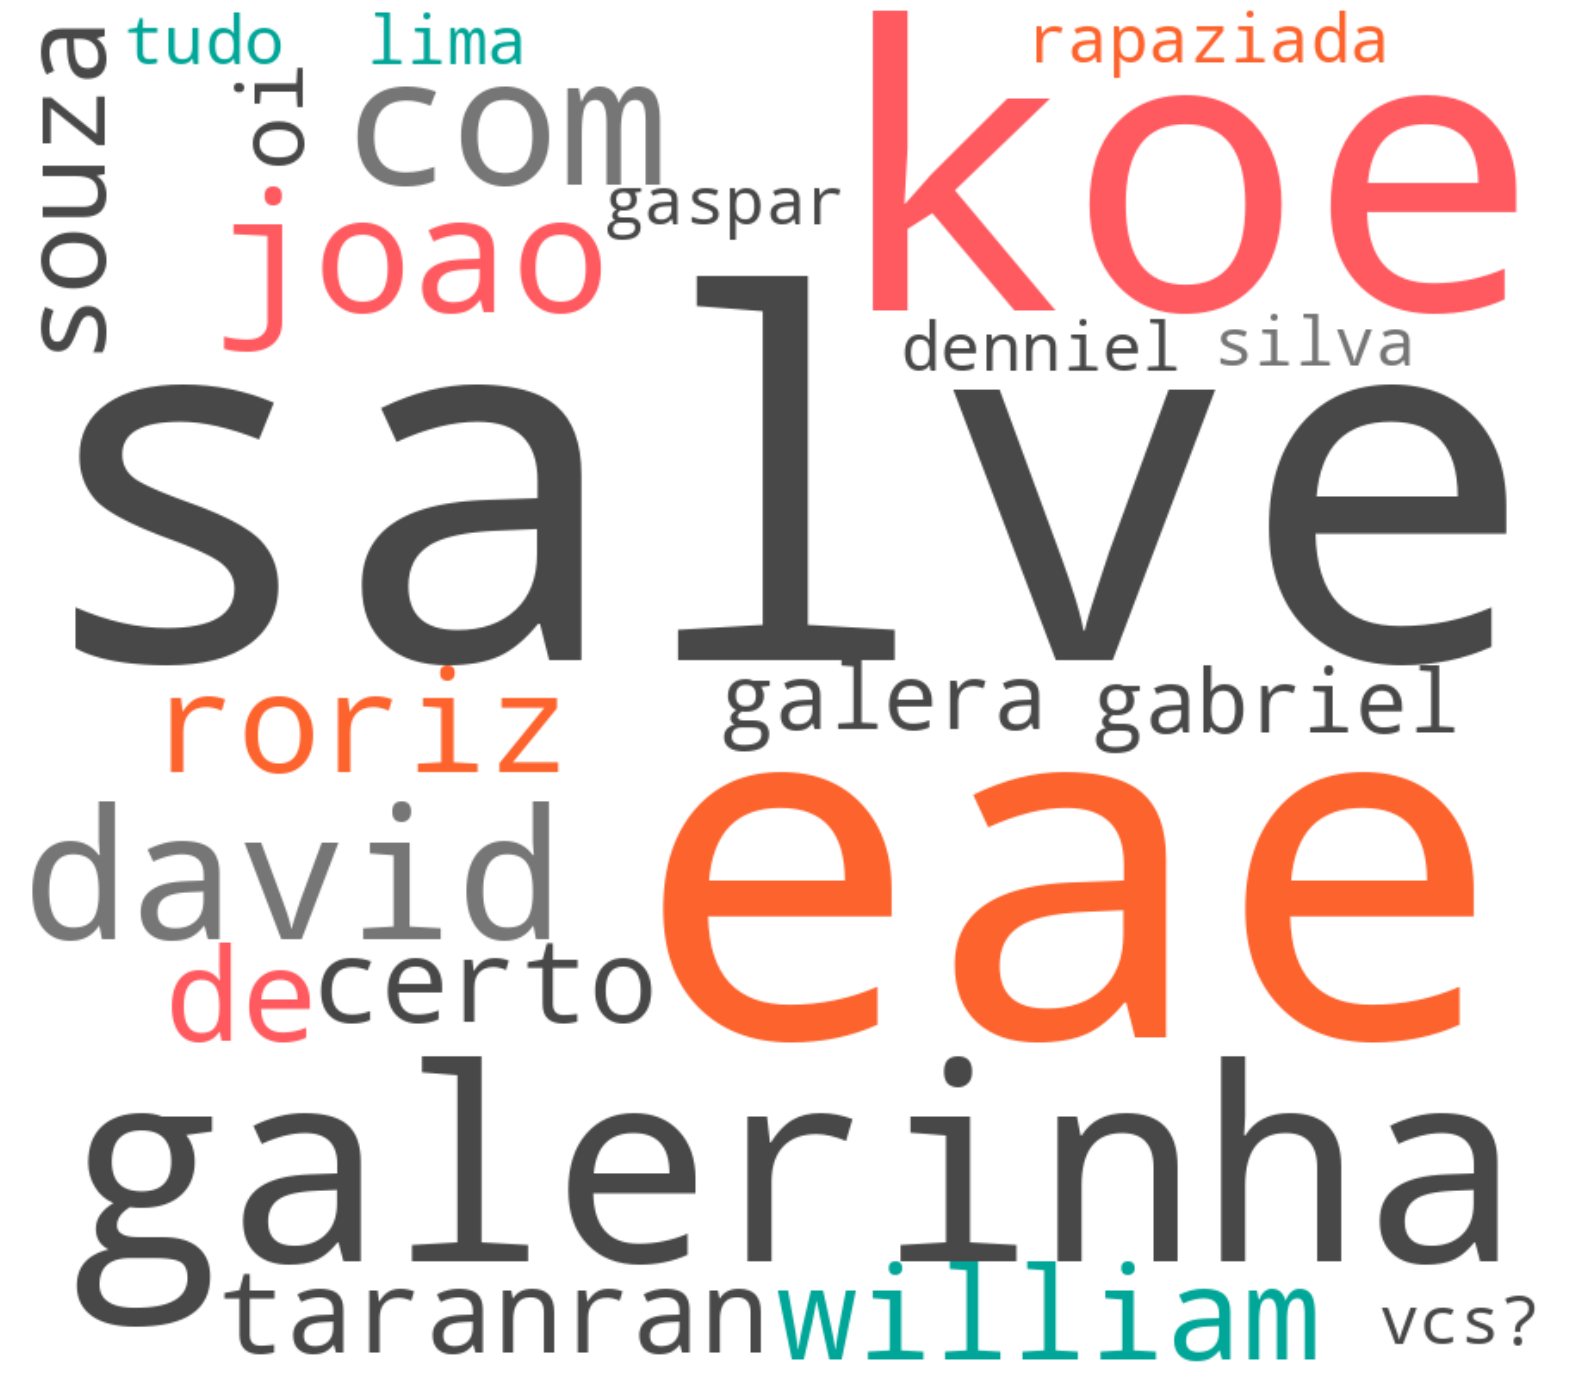

Halting the process for 5 Minutes...


+---------+-----+
|     word|count|
+---------+-----+
|    salve|   13|
|      eae|   12|
|      koe|    8|
|galerinha|    3|
|      com|    1|
|    roriz|    1|
|     joao|    1|
| taranran|    1|
|    souza|    1|
|  william|    1|
|       de|    1|
|  denniel|    1|
|    certo|    1|
|     lima|    1|
|   galera|    1|
|       oi|    1|
|  gabriel|    1|
|rapaziada|    1|
|     vcs?|    1|
|    silva|    1|
+---------+-----+
only showing top 20 rows



22/09/14 16:24:01 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 10000 milliseconds, but spent 21340 milliseconds


KeyboardInterrupt: 

In [6]:
# Read the data stream into memory buffer. 
try:
    query_stream_memory = word_count \
        .writeStream \
        .foreachBatch(generateWordCloud) \
        .option("checkpointLocation", "/tmp/spark/wordcloud") \
        .trigger(processingTime="10 seconds") \
        .outputMode("update") \
        .start() \
        .awaitTermination()
except KeyboardInterrupt:
    print("Finalizando streaming...")

In [ ]:
# Stop the write Streams
query_stream_memory.stop()

# Stop the spark session
spark.stop()